**1.造数据集（S型点云）**

shape of moons: (10000, 2)


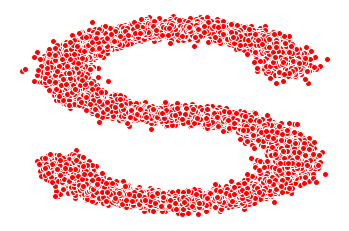

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.datasets import make_s_curve
import torch
import torch.nn as nn
from accelerate import Accelerator
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

s_curve, _ = make_s_curve(10**4, noise=0.1)
s_curve = s_curve[:, [0, 2]] / 10.0
print("shape of moons:", np.shape(s_curve))

data = s_curve.T

fig, ax = plt.subplots()
ax.scatter(*data, color='red', edgecolor='white')

ax.axis('off')
dataset = torch.Tensor(s_curve).float().to('cuda')

**2.设置超参数**

In [26]:
from turtle import shape


num_steps = 100

betas = torch.linspace(-6, 6, num_steps).to('cuda')
betas = torch.sigmoid(betas) * (0.5e-2 - 1e-5) + 1e-5
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1], device='cuda').float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

assert alphas.shape==alphas_prod.shape==alphas_prod_p.shape\
    ==alphas_bar_sqrt.shape==one_minus_alphas_bar_log.shape\
    ==one_minus_alphas_bar_sqrt.shape
print("all the same shape:", betas.shape)

all the same shape: torch.Size([100])


**3.确定扩散过程任意时刻的采样值**

In [27]:
def q_x(x_0, t):
    noise = torch.randn_like(x_0, device='cuda')
    alpha_t = alphas_bar_sqrt[t]
    alphas_l_m_t = one_minus_alphas_bar_sqrt[t]
    return (x_0 * alpha_t + alphas_l_m_t * noise)

**4.原始数据分布加噪100步后的效果**

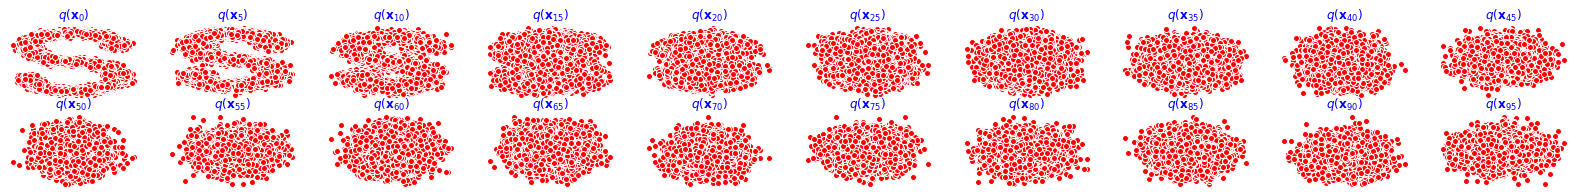

In [28]:
num_shows = 20
fig, axs = plt.subplots(2, 10, figsize=(28, 3))
plt.rc('text', color='blue')
for i in range(num_shows):
    j = i // 10
    k = i % 10
    q_i = q_x(dataset, torch.tensor([i * num_steps // num_shows])).to('cpu')
    axs[j, k].scatter(q_i[:,0], q_i[:,1], color='red', edgecolor='white')

    axs[j, k].set_axis_off()
    axs[j, k].set_title('$q(\mathbf{x}_{' + str(i * num_steps // num_shows) + '})$')

**5.编写简单的模型**

In [29]:
class MLPDiffusion(nn.Module):
    def __init__(self, n_steps, num_units=128):
        super(MLPDiffusion, self).__init__()

        self.linears = nn.ModuleList(
            [
                nn.Linear(2, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, 2),
            ]
        )
        self.step_embeddings = nn.ModuleList(
            [
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units),
            ]
        )
    
    def forward(self, x_0, t):
        x = x_0
        for idx, embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[idx * 2](x)
            x += t_embedding
            x = self.linears[idx * 2 + 1](x)
        
        x = self.linears[-1](x)

        return x

**6.编写误差函数(MSE)**

In [30]:
def diffusion_loss_fn(model, x_0, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, n_steps):
    batch_size = x_0.shape[0]
    
    t = torch.randint(0, n_steps, size=(batch_size // 2,), device='cuda')
    t = torch.cat([t, n_steps - 1 - t], dim=0)
    t = t.unsqueeze(-1)

    a = alphas_bar_sqrt[t]
    aml = one_minus_alphas_bar_sqrt[t]
    e = torch.randn_like(x_0, device='cuda')
    x = x_0 * a + e * aml
    output = model(x, t.squeeze(-1))

    return (e - output).square().mean()

**7.逆扩散过程采样函数**

In [31]:
def p_sample(model, x, t, betas, one_minus_alphas_bar_sqrt):
    t = torch.tensor([t], device='cuda')
    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]
    eps_theta = model(x, t)
    mean = (1 / (1 - betas[t]).sqrt()) * (x - (coeff * eps_theta))
    z = torch.randn_like(x, device='cuda')
    sigma_t = betas[t].sqrt()
    sample = mean + sigma_t * z
    return (sample)

def p_sample_loop(model, shape, n_steps, betas, one_minus_alphas_bar_sqrt):
    cur_x = torch.randn(shape, device='cuda')
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i, betas, one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq

**8.训练模型并打印loss及中间重构效果**

tensor(0.5236, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3847, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2839, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3126, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4514, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3254, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3586, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7139, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3776, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3026, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1741, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4891, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3823, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4419, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2863, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3614, device='cuda:0',

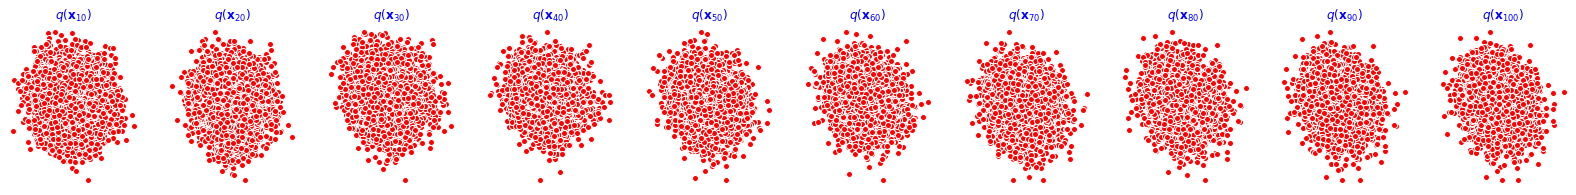

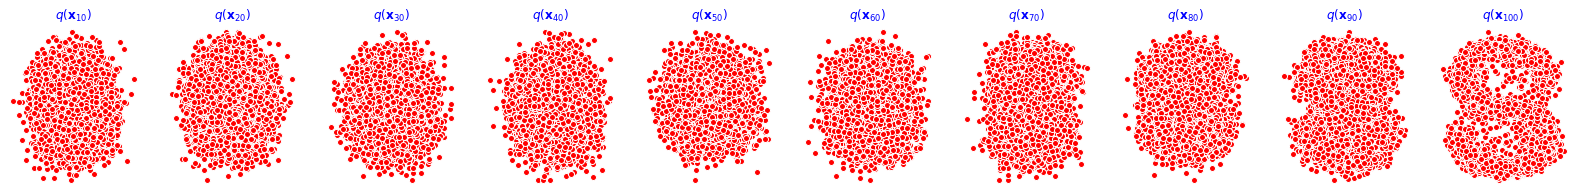

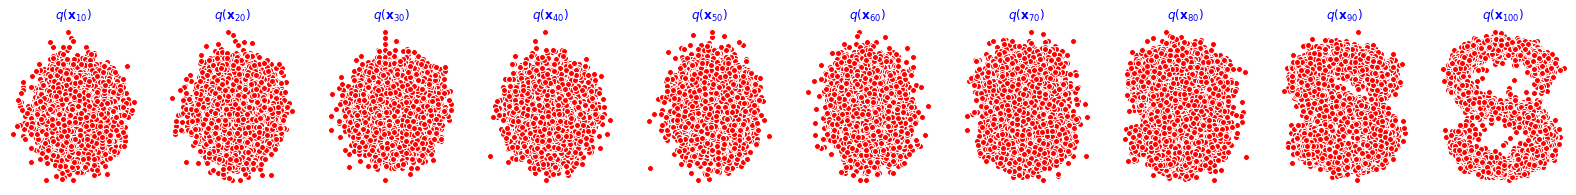

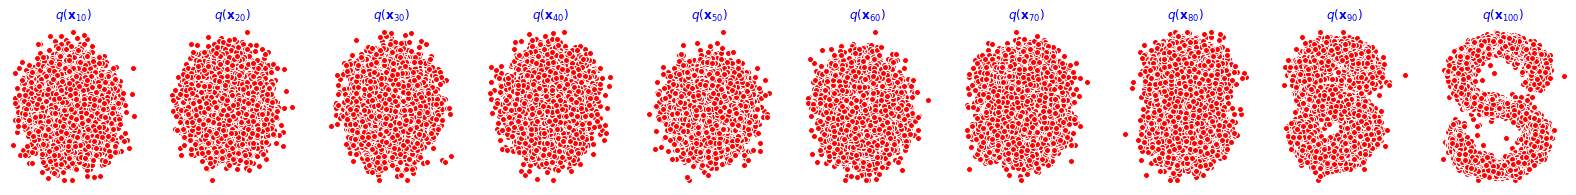

In [33]:
from pickletools import optimize


batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
num_epoch = 4000
plt.rc('text', color='blue')

accelerator = Accelerator()
model = MLPDiffusion(num_steps)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model, optimizer, dataloader = accelerator.prepare(model, optimizer, dataloader)

for epoch in range(num_epoch):
    for idx, batch_x in enumerate(dataloader):
        loss = diffusion_loss_fn(model, batch_x, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps)
        optimizer.zero_grad()
        accelerator.backward(loss)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()

    if epoch % 100 == 0:
        print(loss)

    if epoch % 1000 == 0:
        x_seq = p_sample_loop(model, dataset.shape, num_steps, betas, one_minus_alphas_bar_sqrt)

        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach().to('cpu')
            axs[i - 1].scatter(cur_x[:, 0], cur_x[:, 1], color='red', edgecolor='white')
            axs[i - 1].set_axis_off()
            axs[i - 1].set_title('$q(\mathbf{x}_{' + str(i * 10) + '})$')

In [34]:
torch.save(model.state_dict(), './curve_defussion.pth')